In [287]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score

import seaborn as sns
from sklearn.metrics import f1_score
from localcider.sequenceParameters import SequenceParameters

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.over_sampling import ADASYN


# Q: Are we missing AD tiles?
Plan: build a classifier using constraint/conservation/disorder
- Curious how it compares to activity predictors

In [86]:
classifier_input = pd.read_csv("../data/classifier_input_all_TFs.csv", index_col = 0)
classifier_input["AD_suffic_overlap"] = classifier_input["AD_suffic_overlap"].fillna(False)
classifier_input["tile_len"] = classifier_input["ProteinWindowSeq"].str.len()
classifier_input = classifier_input[classifier_input["tile_len"] == 40]
classifier_input

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_86141/422241582.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  classifier_input["AD_suffic_overlap"] = classifier_input["AD_suffic_overlap"].fillna(False)


,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,tile_len
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,0,40,97.5,NaN,0.954392,NaN,False,40
1,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,40,80,65.0,NaN,1.097658,NaN,False,40
2,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,80,120,85.0,NaN,1.343217,NaN,False,40
3,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,120,160,100.0,NaN,2.062525,NaN,False,40
4,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,160,200,100.0,NaN,1.993300,NaN,False,40
...,...,...,...,...,...,...,...,...,...,...
24771,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False,40
24772,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False,40
24773,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False,40
24774,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False,40


In [87]:
classifier_input["null_vals"] = classifier_input["percent_disorder"].isna().astype(int) \
                                + classifier_input["avg_percent_identity"].isna().astype(int) \
                                + classifier_input["average_PhyloP"].isna().astype(int) \
                                + classifier_input["average_MTR"].isna().astype(int)
classifier_input

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,tile_len,null_vals
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,0,40,97.5,NaN,0.954392,NaN,False,40,2
1,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,40,80,65.0,NaN,1.097658,NaN,False,40,2
2,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,80,120,85.0,NaN,1.343217,NaN,False,40,2
3,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,120,160,100.0,NaN,2.062525,NaN,False,40,2
4,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,160,200,100.0,NaN,1.993300,NaN,False,40,2
...,...,...,...,...,...,...,...,...,...,...,...
24771,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False,40,0
24772,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False,40,0
24773,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False,40,0
24774,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False,40,0


In [88]:
# Drop everything with 2 or 3 null values
# Impute the rest
classifier_input["null_vals"].value_counts()

null_vals
0    14955
1     6987
2      932
3      326
Name: count, dtype: int64

In [89]:
classifier_input = classifier_input[classifier_input["null_vals"] <= 1]
classifier_input

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,tile_len,null_vals
14,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFG,0,40,100.0,88.274793,3.289500,0.965217,False,40,0
15,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,PLTTPTKPKEGSQGEPWTPTANLKMLISAVSPEIRNRDQK,40,80,70.0,94.953512,3.192567,0.980011,False,40,0
16,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,RGLFDNRSGLPEAKDCIHEHLSGDEFEKSQPSRKEKSLGL,80,120,100.0,88.279959,3.859350,0.944093,False,40,0
17,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,LCHKFLARYPNYPNPAVNNDICLDEVAEELNVERRRIYDI,120,160,45.0,97.561983,4.774683,0.923881,False,40,0
18,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,VNVLESLHMVSRLAKNRYTWHGRHNLNKTLGTLKSIGEEN,160,200,60.0,93.600207,4.280983,0.920742,False,40,0
...,...,...,...,...,...,...,...,...,...,...,...
24771,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False,40,0
24772,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False,40,0
24773,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False,40,0
24774,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False,40,0


In [266]:
X = classifier_input[["percent_disorder", "avg_percent_identity", "average_PhyloP", "average_MTR"]]
y = classifier_input[["AD_suffic_overlap"]]

In [267]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

imputer = IterativeImputer()
imputer.fit(X)
X_imputed = imputer.transform(X)
print(X_imputed)

[[100.          88.27479339   3.2895       0.96521691]
 [ 70.          94.9535124    3.19256667   0.98001141]
 [100.          88.27995868   3.85935      0.94409322]
 ...
 [  0.          98.14956332   4.33190833   0.92388832]
 [  2.5         98.02947598   4.15014167   0.85155734]
 [ 67.5         95.44759825   3.9691       0.8028529 ]]


In [268]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_before_resampling, X_test, y_train_before_resampling, y_test = train_test_split(X_knn_imputed, y, test_size=0.2, random_state=42) #

In [285]:
sum(y_train_before_resampling["AD_suffic_overlap"]) / len(y_train_before_resampling)

0.06716800546915057

In [286]:
sum(y_test["AD_suffic_overlap"]) / len(y_test)

0.062428799270904535

In [270]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_before_resampling, y_train_before_resampling)  

In [271]:
# ada = ADASYN(random_state=130)
# X_train, y_train = ada.fit_resample(X_train_before_resampling, y_train_before_resampling)  

# 1. Trying out classifiers
Which classifier can best use conservation and constraint to annotate an AD?

## A. Decision tree

In [272]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.7723855092276145
F1: 0.16261525565800503


In [273]:
# fig = plt.figure(figsize=(6,2), dpi = 300)
# _ = tree.plot_tree(clf, 
#                    filled=True,
#                    feature_names=X_train.columns,
#                   class_names = ["Not AD", "AD"])

In [274]:
pd.DataFrame({"feature" : X.columns, "importance" : clf.feature_importances_}).sort_values(by = "importance", ascending = False)

,feature,importance
1,avg_percent_identity,0.321045
2,average_PhyloP,0.318500
3,average_MTR,0.191065
0,percent_disorder,0.169390


## B. KNN

In [275]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.7568922305764411
F1: 0.16705698672911787


## C. Random forest

In [288]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.8042834358623833
F1: 0.20683287165281625


In [289]:
from matplotlib import cm
from matplotlib.colors import Normalize


In [290]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TP = cm[1, 1]  # True Positive
FP = cm[0, 1]  # False Positive
TN = cm[0, 0]  # True Negative
FN = cm[1, 0]  # False Negative

# Calculate metrics
TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity)
FPR = FP / (FP + TN)  # False Positive Rate (1 - Specificity)
Precision = precision_score(y_test, y_pred)  # Precision
Accuracy = accuracy_score(y_test, y_pred)  # Accuracy

# Print metrics
print(f"True Positive Rate (TPR): {TPR}")
print(f"False Positive Rate (FPR): {FPR}")
print(f"Precision: {Precision}")
print(f"Accuracy: {Accuracy}")

True Positive Rate (TPR): 0.40875912408759124
False Positive Rate (FPR): 0.16938031591737546
Precision: 0.138442521631644
Accuracy: 0.8042834358623833


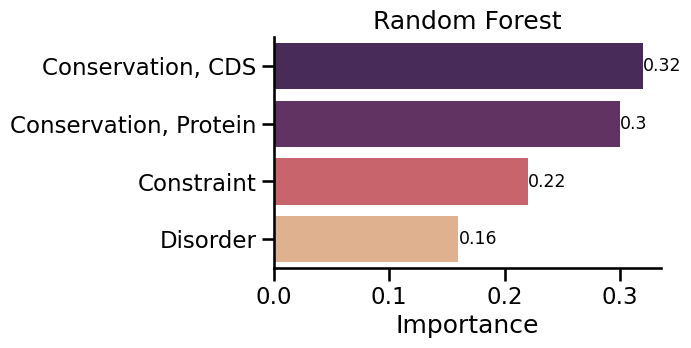

In [278]:
sns.set_context('talk')
plt.figure(figsize = (5, 3), dpi = 100)
rf_feat_imp = pd.DataFrame({"feature" : X.columns, 
              "importance" : rf_clf.feature_importances_}).sort_values(by = "importance", 
                                                                       ascending = False)
rf_feat_imp["importance"] = rf_feat_imp["importance"].round(2)

rename_features = {"average_PhyloP" : "Conservation, CDS", 
                   "avg_percent_identity" : "Conservation, Protein", 
                   "average_MTR" : "Constraint", 
                   "percent_disorder" : "Disorder"}
rf_feat_imp["feature"] = rf_feat_imp["feature"].map(rename_features)

ax = sns.barplot(data = rf_feat_imp, y = "feature", x = "importance", palette = "flare", hue = "importance", legend = False)
ax.bar_label(ax.containers[0], fontsize="x-small");
ax.bar_label(ax.containers[1], fontsize="x-small");
ax.bar_label(ax.containers[2], fontsize="x-small");
ax.bar_label(ax.containers[3], fontsize="x-small");

plt.xlabel("Importance")
plt.ylabel("")
plt.title("Random Forest")
sns.despine()

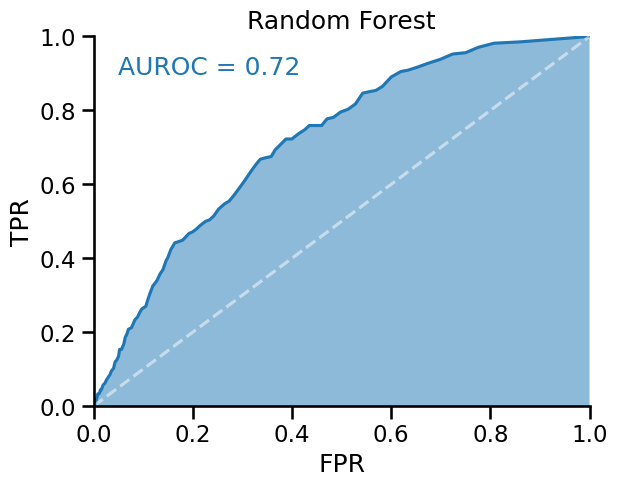

In [279]:
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest")
#plt.legend()

plt.fill_between(fpr, tpr, alpha = 0.5)
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'white', alpha = 0.5) 

plt.text(x = 0.05, y = 0.95, s ='AUROC = %0.2f' % roc_auc, ha = "left", va = "top", color = sns.color_palette('tab10')[0])

plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine();

## D. Logistic regression

In [280]:
# import the class
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.6167691957165642
F1: 0.20735155513666353


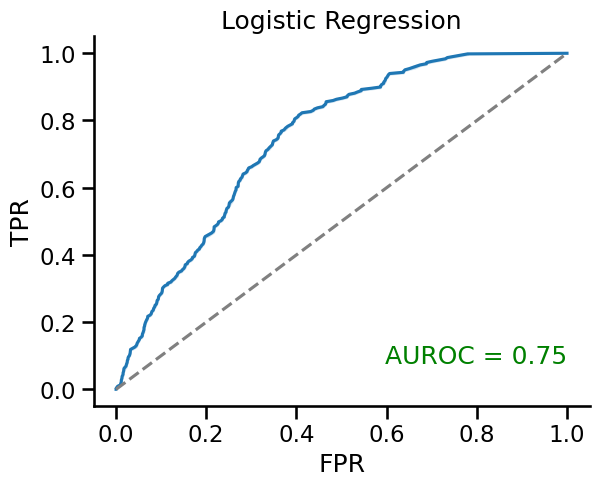

In [281]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.text(x = 1, y = 0.1, s ='AUROC = %0.2f' % roc_auc, ha = "right", va = "center", color = 'green')
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'gray') 
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression")
#plt.legend()
sns.despine();

## Random forest had the best performance.

# 2. Sequence alone performs better

In [298]:
# AA counts
AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

for AA in AAs:
    classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)

classifier_input

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_86141/4008737939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)
/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_86141/4008737939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)
/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_86141/4008737939.py:5: SettingWithCopyWarning: 
A

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,tile_len,...,M,N,P,Q,R,S,T,V,W,Y
14,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFG,0,40,100.0,88.274793,3.289500,0.965217,False,40,...,2,3,3,1,1,1,3,1,0,0
15,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,PLTTPTKPKEGSQGEPWTPTANLKMLISAVSPEIRNRDQK,40,80,70.0,94.953512,3.192567,0.980011,False,40,...,1,2,6,2,2,3,5,1,1,0
16,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,RGLFDNRSGLPEAKDCIHEHLSGDEFEKSQPSRKEKSLGL,80,120,100.0,88.279959,3.859350,0.944093,False,40,...,0,1,2,1,3,5,0,0,0,0
17,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,LCHKFLARYPNYPNPAVNNDICLDEVAEELNVERRRIYDI,120,160,45.0,97.561983,4.774683,0.923881,False,40,...,0,5,3,0,4,0,0,3,0,3
18,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,VNVLESLHMVSRLAKNRYTWHGRHNLNKTLGTLKSIGEEN,160,200,60.0,93.600207,4.280983,0.920742,False,40,...,1,5,0,0,3,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24771,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False,40,...,0,2,5,1,1,9,2,2,0,2
24772,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False,40,...,0,2,2,1,0,6,2,1,1,0
24773,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False,40,...,0,0,1,5,7,0,1,3,0,3
24774,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False,40,...,1,0,0,6,3,3,1,1,0,5


In [304]:
#AAs.append("AD_suffic_overlap")
X = classifier_input[AAs]
y = classifier_input[["AD_suffic_overlap"]]

In [305]:
X_train_before_resampling, X_test, y_train_before_resampling, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_before_resampling, y_train_before_resampling)  

In [306]:
# import the class
logreg = LogisticRegression()
logreg.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.9366598313966735
F1: 0.027972027972027972


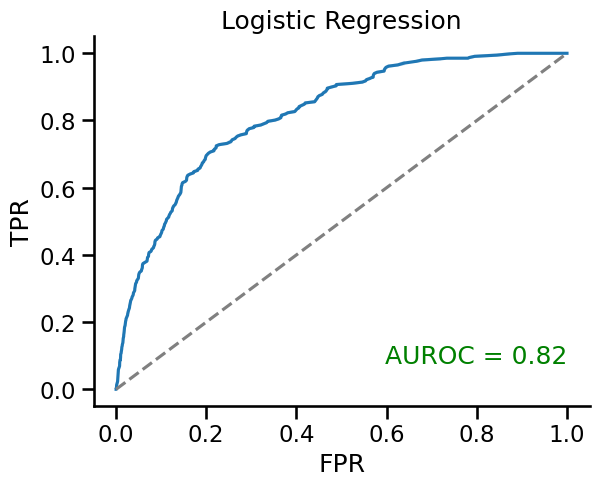

In [312]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.text(x = 1, y = 0.1, s ='AUROC = %0.2f' % roc_auc, ha = "right", va = "center", color = 'green')
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'gray') 
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression")
#plt.legend()
sns.despine();

In [308]:
# Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.9216222374117111
F1: 0.33073929961089493


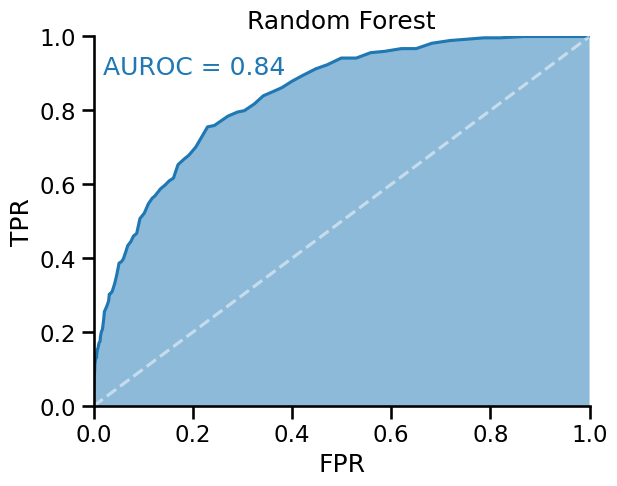

In [311]:
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest")
#plt.legend()

plt.fill_between(fpr, tpr, alpha = 0.5)
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'white', alpha = 0.5) 

plt.text(x = 0.02, y = 0.95, s ='AUROC = %0.2f' % roc_auc, ha = "left", va = "top", color = sns.color_palette('tab10')[0])

plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine();

# 3. Using position too?

In [336]:
pos_input = classifier_input[["ProteinWindowSeq", "AD_suffic_overlap"]]
pos_input_expanded = pos_input["ProteinWindowSeq"].str.split("", expand=True).iloc[:, 1:-1]
pos_input = pd.concat([pos_input_expanded], axis=1)

In [326]:
from sklearn.preprocessing import OneHotEncoder

In [337]:
categorical_columns =pos_input.columns.to_list()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(pos_input)
one_hot_df = pd.DataFrame(one_hot_encoded)
X = one_hot_df
X

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21937,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21938,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
X_train_before_resampling, X_test, y_train_before_resampling, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_before_resampling, y_train_before_resampling)  

In [339]:
# import the class
logreg = LogisticRegression()
logreg.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.7792207792207793
F1: 0.2631178707224335


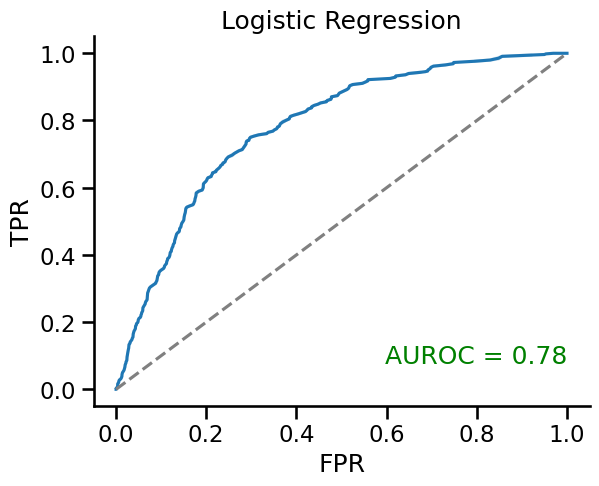

In [340]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.text(x = 1, y = 0.1, s ='AUROC = %0.2f' % roc_auc, ha = "right", va = "center", color = 'green')
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'gray') 
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression")
#plt.legend()
sns.despine();

In [341]:
# Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score(y_test, y_pred)}')

Accuracy: 0.9421280473912053
F1: 0.1360544217687075


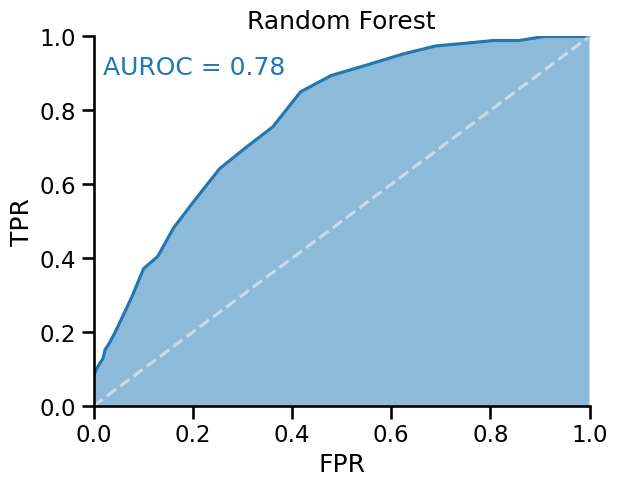

In [342]:
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, )
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest")
#plt.legend()

plt.fill_between(fpr, tpr, alpha = 0.5)
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'white', alpha = 0.5) 

plt.text(x = 0.02, y = 0.95, s ='AUROC = %0.2f' % roc_auc, ha = "left", va = "top", color = sns.color_palette('tab10')[0])

plt.xlim(0, 1)
plt.ylim(0, 1)

sns.despine();

# 2. How well I predict conservation and constraint from sequence?

Ideas: 
- Count of AA occurrence (20 features)
- CIDER features (4 features)
    - get_fraction_negative()
    - get_fraction_positive()
    - get_fraction_disorder_promoting()
    - get_NCPR(pH=None)	

In [372]:
import localcider

In [350]:
classifier_input

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap
0,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,0,40,100.0,34.687500,0.029225,1.083595,False
1,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,40,80,100.0,9.458333,-0.050108,1.117582,False
2,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,80,120,12.5,65.270833,-0.083100,1.140393,False
3,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,120,160,72.5,60.614583,-0.170567,0.972334,False
4,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,160,200,100.0,48.104167,0.087592,0.974269,True
...,...,...,...,...,...,...,...,...,...
5293,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False
5294,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False
5295,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False
5296,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False


### 2.1 Getting features for each sequence

In [278]:
# AA counts
AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

for AA in AAs:
    classifier_input[AA] = classifier_input["ProteinWindowSeq"].str.count(AA)

classifier_input

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,A,...,M,N,P,Q,R,S,T,V,W,Y
0,sp|P57082|TBX4_HUMAN T-box transcription facto...,MLQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLS,0,40,100.0,76.096674,4.061383,0.989720,False,10,...,1,1,5,1,1,4,0,0,0,0
1,sp|P57082|TBX4_HUMAN T-box transcription facto...,LQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSG,1,41,100.0,75.415800,4.059750,0.989938,False,10,...,0,1,5,1,1,4,0,0,0,0
2,sp|P57082|TBX4_HUMAN T-box transcription facto...,QDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGA,2,42,100.0,73.581081,4.006308,0.989938,False,11,...,0,1,5,1,1,4,0,0,0,0
3,sp|P57082|TBX4_HUMAN T-box transcription facto...,DKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAA,3,43,100.0,73.316008,3.953917,0.991008,False,12,...,0,1,5,0,1,4,0,0,0,0
4,sp|P57082|TBX4_HUMAN T-box transcription facto...,KGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAAL,4,44,100.0,73.092516,3.971133,0.992078,False,12,...,0,1,5,0,1,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204642,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,TQIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIR,199,239,62.5,98.180873,5.216000,0.828336,False,2,...,0,1,3,2,5,2,3,2,0,1
204643,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,QIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRK,200,240,55.0,98.186071,5.194808,0.828068,False,2,...,0,1,3,2,5,2,2,2,0,1
204644,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,IRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKM,201,241,57.5,98.180873,5.216000,0.827800,False,2,...,1,1,3,1,5,2,2,2,0,1
204645,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,RVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKMQ,202,242,32.5,98.180873,5.278450,0.827532,False,2,...,1,1,3,2,5,2,2,2,0,1


In [290]:
# CIDER features
classifier_input["frac_neg"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_negative())

In [286]:
classifier_input["frac_pos"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_positive())

In [287]:
classifier_input["frac_disord_prom"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_fraction_disorder_promoting())

In [288]:
classifier_input["ncpr"] = classifier_input["ProteinWindowSeq"].apply(lambda x: SequenceParameters(x).get_NCPR(pH = None))

In [289]:
classifier_input

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,A,...,R,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr
0,sp|P57082|TBX4_HUMAN T-box transcription facto...,MLQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLS,0,40,100.0,76.096674,4.061383,0.989720,False,10,...,1,4,0,0,0,0,0.150,0.050,0.800,-0.100
1,sp|P57082|TBX4_HUMAN T-box transcription facto...,LQDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSG,1,41,100.0,75.415800,4.059750,0.989938,False,10,...,1,4,0,0,0,0,0.150,0.050,0.825,-0.100
2,sp|P57082|TBX4_HUMAN T-box transcription facto...,QDKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGA,2,42,100.0,73.581081,4.006308,0.989938,False,11,...,1,4,0,0,0,0,0.150,0.050,0.850,-0.100
3,sp|P57082|TBX4_HUMAN T-box transcription facto...,DKGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAA,3,43,100.0,73.316008,3.953917,0.991008,False,12,...,1,4,0,0,0,0,0.150,0.050,0.850,-0.100
4,sp|P57082|TBX4_HUMAN T-box transcription facto...,KGLSESEEAFRAPGPALGEASAANAPEPALAAPGLSGAAL,4,44,100.0,73.092516,3.971133,0.992078,False,12,...,1,4,0,0,0,0,0.125,0.050,0.825,-0.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204642,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,TQIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIR,199,239,62.5,98.180873,5.216000,0.828336,False,2,...,5,2,3,2,0,1,0.025,0.225,0.675,0.200
204643,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,QIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRK,200,240,55.0,98.186071,5.194808,0.828068,False,2,...,5,2,2,2,0,1,0.025,0.250,0.675,0.225
204644,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,IRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKM,201,241,57.5,98.180873,5.216000,0.827800,False,2,...,5,2,2,2,0,1,0.025,0.250,0.650,0.225
204645,sp|Q86VZ6|JAZF1_HUMAN Juxtaposed with another ...,RVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKMQ,202,242,32.5,98.180873,5.278450,0.827532,False,2,...,5,2,2,2,0,1,0.025,0.250,0.675,0.225


### 2.2 Trying models

In [291]:
classifier_input.columns

Index(['GeneName', 'ProteinWindowSeq', 'StartPosition', 'EndPosition',
       'percent_disorder', 'avg_percent_identity', 'average_PhyloP',
       'average_MTR', 'AD_suffic_overlap', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
       'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'frac_neg', 'frac_pos', 'frac_disord_prom', 'ncpr'],
      dtype='object')

In [292]:
features = classifier_input.columns[9:]
features

Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'frac_neg', 'frac_pos',
       'frac_disord_prom', 'ncpr'],
      dtype='object')

In [310]:
X = classifier_input[features]
y = classifier_input[["AD_suffic_overlap"]]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.8, random_state=42)

In [311]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8857809141914593


In [312]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, np.array(y_train.iloc[:, 0]))
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9704640835943625


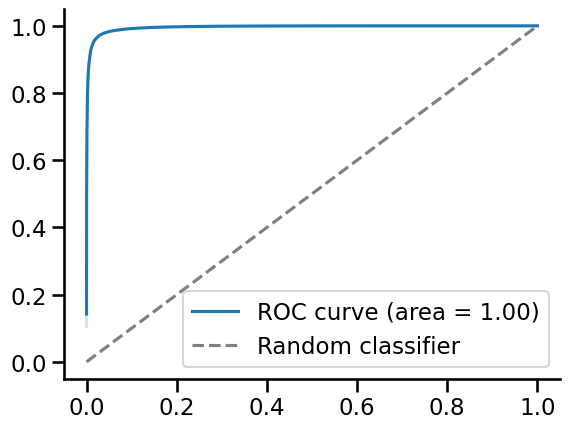

In [313]:
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob) 
sns.set_context('talk')
sns.lineplot(x = fpr, y = tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', label='Random classifier', color = 'gray') 
plt.legend()
sns.despine();

In [314]:
y_test

,AD_suffic_overlap
115948,False
122330,False
258334,True
257611,True
126408,False
...,...
281999,True
275723,True
183536,False
137703,True


In [315]:
X_test

,A,C,D,E,F,G,H,I,K,L,...,R,S,T,V,W,Y,frac_neg,frac_pos,frac_disord_prom,ncpr
115948,3,4,1,0,2,4,4,1,4,3,...,3,2,1,1,2,1,0.025000,0.175000,0.600000,0.150000
122330,4,0,0,0,1,5,2,0,0,2,...,1,7,2,0,0,6,0.000000,0.025000,0.750000,0.025000
258334,2,1,1,3,1,2,2,2,1,10,...,2,1,0,2,2,0,0.122908,0.075000,0.450000,-0.047908
257611,1,0,1,4,2,0,2,1,3,8,...,1,2,0,1,0,2,0.125000,0.100000,0.546147,-0.025000
126408,0,6,3,1,4,1,0,2,4,3,...,3,3,1,1,0,0,0.100000,0.175000,0.475000,0.075000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281999,1,2,1,6,1,2,1,0,3,3,...,1,6,3,4,0,1,0.175000,0.115334,0.690334,-0.059666
275723,4,1,0,2,2,4,1,1,0,1,...,2,5,0,2,0,1,0.050000,0.050000,0.627785,0.000000
183536,3,0,2,7,1,2,0,4,1,1,...,2,4,3,2,1,0,0.225000,0.075000,0.775000,-0.150000
137703,3,0,1,4,0,3,1,2,1,3,...,1,3,1,4,0,1,0.125000,0.050000,0.575000,-0.075000


In [246]:
classifier_input[classifier_input["AD_suffic_overlap"] != classifier_input["rf_pred"]][["AD_suffic_overlap", "rf_pred"]].value_counts()

AD_suffic_overlap  rf_pred
False              True       4107
True               False       988
Name: count, dtype: int64

In [251]:
classifier_input[classifier_input["AD_suffic_overlap"] & ~classifier_input["rf_pred"]]

,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap,rf_pred
506,90.0,93.118221,4.274050,0.924792,True,False
710,20.0,92.049892,4.715483,0.838513,True,False
735,7.5,92.207158,4.716258,0.821601,True,False
1071,100.0,98.351190,5.014142,0.921468,True,False
1116,100.0,97.892857,4.955000,0.887116,True,False
...,...,...,...,...,...,...
203929,100.0,91.188525,5.624933,0.655171,True,False
204059,25.0,96.547131,5.488933,0.487974,True,False
204069,25.0,97.797131,5.417300,0.494559,True,False
204461,22.5,83.378378,5.276867,0.945938,True,False


In [52]:
classifier_input

,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap
0,100.0,76.096674,4.061383,0.989720,False
1,100.0,75.415800,4.059750,0.989938,False
2,100.0,73.581081,4.006308,0.989938,False
3,100.0,73.316008,3.953917,0.991008,False
4,100.0,73.092516,3.971133,0.992078,False
...,...,...,...,...,...
204642,62.5,98.180873,5.216000,0.828336,False
204643,55.0,98.186071,5.194808,0.828068,False
204644,57.5,98.180873,5.216000,0.827800,False
204645,32.5,98.180873,5.278450,0.827532,False


In [255]:
(4107 + 988)  / 204647

0.02489652914530875